In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho):
    '''Given a list of strike prices and SABR parameters, returns what the SABR
    model predicts the market volatility to be. Calculated from equations (2.17) 
    and (2.18) in Hagan, Patrick S., Deep Kumar, Andrew S. Lesniewski, and 
    Diana E. Woodward "Managing smile risk." The Best of Wilmott 1 (2002): 249-296.
    '''
    output = np.zeros(len(K))
    
    for i in range(0,len(K)):
        if K[i] == f: #ATM equation in Managing smile risk
            part_1 = (1.0 - beta)**2.0*alpha**2.0/(24.0*f**(2.0 - 2.0*beta))
            part_2 = rho*beta*alpha*nu/(4.0*f**(1.0 - beta))
            part_3 = (2.0 - 3.0*rho**2)*nu**2.0/24.0
            
            output[i] = (alpha/f**(1 - beta))*(1 + (part_1 + part_2 + part_3)*t_exp )
        
        else:
            logfK = np.log(f/K[i])
            fkbpow = (f*K[i])**((1.0 - beta)/2.0)
            z = nu*fkbpow*logfK/alpha
            xz = np.log((np.sqrt(1.0 - 2.0*rho*z + z**2.0 ) + z - rho)/(1.0-rho))
            
            part_1 = ((1.0-beta)**2.0)*(alpha**2.0)/(24.0*fkbpow**2.0)
            part_2 = (rho*beta*nu*alpha)/(4.0*fkbpow)
            part_3 = (2.0-3.0*rho**2)*nu**2.0/24.0
            part_4 = ((1.0-beta)**2)*(logfK**2)/24.0
            part_5 = ((1.0-beta)**4)*(logfK**4)/1920.0
            
            output[i] = (alpha*z*(1 + (part_1 + part_2 + part_3)*t_exp ))/(fkbpow*xz*(1 + part_4 + part_5 ))
            
    return output

def atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho):
    '''Returns alpha given the forward price, the at-the-money volatility, the 
    time to exirpy (t_exp) and the other parameters in the SABR model by 
    solving a cubic equation for alpha, equation (2.18) in Hagan, Patrick S., 
    Deep Kumar, Andrew S. Lesniewski, and Diana E. Woodward. 
    "Managing smile risk." The Best of Wilmott 1 (2002): 249-296. 
    '''
    #The coeffceints of the polynomial we find the roots of
    p_3 = -sigma_atm
    p_2 =  (1 + (2-3*rho**2)*nu**2*t_exp/24)/f**(1.-beta)
    p_1 = rho*beta*nu*t_exp/(4*f**(2-2*beta))
    p_0 = (1-beta)**2*t_exp/(24*f**(3-3*beta))
    coeffs = [p_0,p_1,p_2,p_3]
    
    r = np.roots(coeffs)    #find the roots of the cubic equation
    
    return r[(r.imag==0) & (r.real>=0)].real.min() 

def SABR_calibration(f, t_exp, sigma_atm, beta, strikes, vols,guess):
    ''' Returns the parameters alpha, nu and rho given a parameter beta, 
    forward price, a list of market volatilities and corrsponding strike 
    spread. Instead of doing a regression in all three parameters, this method 
    calculates alpha when needed from nu and rho. Hence a regression is done 
    in only two variables.
    '''
    def func_to_optimize(K,nu,rho):
        alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
        return  SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho)
     
    popt, pcov = curve_fit(func_to_optimize, strikes, vols, p0 = (guess[1],guess[2]), maxfev=10000)
      
    nu = popt[0]
    rho = popt[1]
    alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
    
    return [alpha, nu, rho]
        


#10Y30Y 2024
beta = 1
sigmas = np.array([0.4364, 0.4191, 0.41706,0.41605, 0.41619,0.41757,0.42003,0.42370,0.42847,0.43428,0.46603])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 30
atm_sigma = 0.41757
f = 0.23401
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)



alpha: 0.1582037594078576 rho: 0.12213438727498692 nu: 1.3892400012537673


In [2]:
#10Y20Y 2024
beta = 1
sigmas1 = np.array([0.44983,	0.43478,	0.43329,	0.43288,	0.43360,
                   	0.43559,	0.43846,	0.44256,	0.44772,	0.45385,	0.48650])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 20
atm_sigma = 0.43559
f = 0.251744
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas1, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)


alpha: 0.1581059478666176 rho: 0.14564752039479514 nu: 1.4396371433086788


In [3]:
#10Y15Y 2024
beta = 1
sigmas2 = np.array([0.46292,	0.44963,	0.44859,	0.44862,	0.44974,
                    0.45247,	0.45530,	0.45970,	0.46509,	0.47143,	0.50457])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 15
atm_sigma = 0.45247
f = 0.265454
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas2, guess)
print("alpha:",alpha,"rho:",rho, "nu:", nu)   


alpha: 0.15985856259615347 rho: 0.1623868093393327 nu: 1.4722802470849656


In [4]:
#10Y12Y 2024
beta = 1
sigmas3 = np.array([0.47487,	0.46379,	0.46305,	0.46334,	0.46470,
                    0.46781,	0.47064,	0.47517,	0.48068,	0.48709,	0.52033])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 12
atm_sigma = 0.46781
f = 0.2276305
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas3, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)


alpha: 0.18030958709384343 rho: 0.17623198188430858 nu: 1.367529397820228


alpha: 0.1647107136610676 rho: 0.17994820670459657 nu: 1.5155172178851308


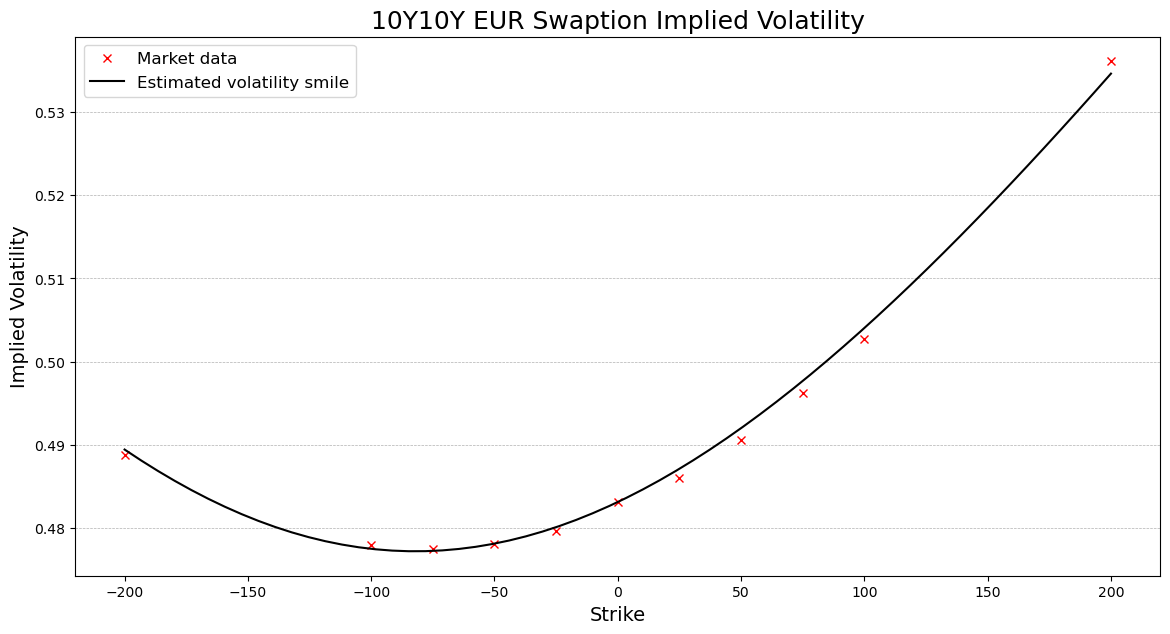

In [5]:
#10Y10Y 2024
beta = 1
sigmas4 = np.array([0.48882,	0.47796,	0.47750,	0.47806,	0.47966,
                    0.48315,	0.48598,	0.49065,	0.49626,	0.50275,	0.53610])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 10
atm_sigma = 0.48315
f = 0.284018
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas4, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)

Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas4, 'x', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
plt.title("10Y10Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y10Y_est_beta_1.png")  
plt.show()
plt.close()


In [11]:
#10Y7Y 2024
beta = 1
sigmas5 = np.array([0.49234,	0.48694,	0.48762,	0.48916,	0.49157,
                    0.49531,	0.49896,	0.50388,	0.50955,	0.51594,	0.54749])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 7
atm_sigma = 0.49531
f = 0.294395
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas5, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)


alpha: 0.1721512633148142 rho: 0.217692452102457 nu: 1.4978993417202757


In [12]:
#10Y5Y 2024
beta = 1
sigmas6 = np.array([0.49781,	0.49597,	0.49735,	0.49950,	0.50241,
                    0.50614,	0.51043,	0.51549,	0.52119,	0.52750,	0.55792])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 5
atm_sigma = 0.50614
f = 0.299258
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas6, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)


alpha: 0.17869377471892967 rho: 0.24296640919485088 nu: 1.4834331489812376


In [13]:
#10Y3Y 2024
beta = 1
sigmas7 = np.array([0.50699,	0.50806,	0.51017,	0.51304,	0.51665,
                    0.52101,	0.52599,	0.53166,	0.53795,	0.54480,	0.57709])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 3
atm_sigma = 0.52101
f = 0.299622
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas7, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)


alpha: 0.1831614144710937 rho: 0.2772599993359734 nu: 1.4979925918268875


In [14]:
#10Y2Y 2024
beta = 1
sigmas8 = np.array([0.51588,	0.51864,	0.52116,	0.52442,	0.52841,
                    0.53311,	0.53845,	0.54444,	0.55102,	0.55815,	0.59138])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 2
atm_sigma = 0.53311
f = 0.297602
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas8, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)

plt.close()

alpha: 0.18764888571323837 rho: 0.2947266854728685 nu: 1.501256857501689


In [15]:
#10Y1Y 2024
beta = 1
sigmas9 = np.array([0.51416,	0.51819,	0.52105,	0.52465,	0.52898,
                    0.53399,	0.53966,	0.54596,	0.55283,	0.56025,	0.59448])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 1
atm_sigma = 0.53399
f = 0.293838
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas9, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)


alpha: 0.1891903170744875 rho: 0.31148575079566587 nu: 1.4997337847095888
